# Изучение архитектуры на основе LeNet в PyTorch

## Импорт библиотек

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

import os
import copy
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision
from torchvision import transforms, datasets
import torchvision.transforms as T

from torchsummary import summary

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from tqdm.notebook import tqdm, trange

import pandas as pd

## Настройка работы с PyTorch

In [ ]:
def torch_stats():
    torch_version = ".".join(torch.__version__.split(".")[:2])
    print('torch version:',torch_version)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Using device:', device)
    dtype = torch.float32

    if device.type == 'cuda':
        cuda_version  = torch.__version__.split("+")[-1]
        print("cuda: ", cuda_version)

        torch.set_default_tensor_type(torch.cuda.FloatTensor)
        print('Cuda is available:',torch.cuda.is_available())

        n_devices = torch.cuda.device_count()
        print('number of devices: %d'%(n_devices))

        for cnt_device in range(n_devices):
            print(torch.cuda.get_device_name(cnt_device))
            print('Memory Usage:')
            print('Allocated:', round(torch.cuda.memory_allocated(cnt_device)/1024**3,1), 'GB')
            print('Cached:   ', round(torch.cuda.memory_reserved(cnt_device)/1024**3,1), 'GB')


    torch.set_default_dtype(dtype) # float32
    print('default data type:',dtype)

    num_workers=os.cpu_count()
    print ('available number of workers:',num_workers)

    return device, dtype, num_workers
#-------------------------------
def torch_seed(seed = 42, deterministic = True):
    random.seed(seed) # random and transforms
    np.random.seed(seed) #numpy
    torch.manual_seed(seed) #cpu
    torch.cuda.manual_seed(seed) #gpu
    torch.backends.cudnn.deterministic=deterministic #cudnn

In [ ]:
device, dtype, num_workers = torch_stats()
torch_seed(seed = 42, deterministic = True)

torch version: 2.1
Using device: cpu
default data type: torch.float32
available number of workers: 2


## Архитекутра LeNet

In [ ]:
class LeNet(nn.Module):

    def __init__(self, in_channels, n_classes):
        super().__init__()

        self.in_channels = in_channels
        self.n_classes   = n_classes

        # convolution
        self.conv1   = nn.Conv2d(in_channels  = self.in_channels,
                                 out_channels = 6,
                                 kernel_size  = 5)


        self.conv2   = nn.Conv2d(in_channels  = 6,
                                 out_channels = 16,
                                 kernel_size  = 5)

        # pooling
        self.pool = nn.AvgPool2d(kernel_size = 2,
                                 stride      = 2)

        # classification
        self.fc1 = nn.Linear(in_features  = 16 * 5 * 5,
                             out_features = 120)

        self.fc2 = nn.Linear(in_features  = 120,
                             out_features = 84)

        self.fc_out = nn.Linear(in_features = 84,
                                out_features = self.n_classes)

    def flatten(self, x):
        # 16 feature map with size 5 x 5
        return x.view(-1, 16 * 5 * 5)

    def forward(self, x):

        # 1-st layer
        x = self.conv1(x)
        x = torch.tanh(x)
        x = self.pool(x)

        #2-nd layer
        x = self.conv2(x)
        x = torch.tanh(x)
        x = self.pool(x)

        #flatten
        x = self.flatten(x)

        # 1-st fc layer
        x = self.fc1(x)
        x = torch.tanh(x)

        # 2-nd fc layer
        x = self.fc2(x)
        x = torch.tanh(x)

        # output layer
        x = self.fc_out(x)

        return x#torch.softmax(x, dim=1)

In [ ]:
model = LeNet(3,10)

# from torchsummary import summary
summary(model, input_size = (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         AvgPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         AvgPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


## Упражнения

### 1. Проверьте помогает ли для увеличения точности использование агументации, изученное в предыдущей работе.

#### Рассмотрим случай с использованием аугментации

In [ ]:
params = list(model.named_parameters())

# print(params)
for idx in range(len(params)):
    print(params[idx][0],'\t', params[idx][1].size())
print('\n',10*'--')
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of trainable parameters for the model: %d' % (num_params))

num_params = sum(p.numel() for p in model.parameters() )
print('Number of all parameters for the model: %d' % (num_params))

conv1.weight 	 torch.Size([6, 3, 5, 5])
conv1.bias 	 torch.Size([6])
conv2.weight 	 torch.Size([16, 6, 5, 5])
conv2.bias 	 torch.Size([16])
fc1.weight 	 torch.Size([120, 400])
fc1.bias 	 torch.Size([120])
fc2.weight 	 torch.Size([84, 120])
fc2.bias 	 torch.Size([84])
fc_out.weight 	 torch.Size([10, 84])
fc_out.bias 	 torch.Size([10])

 --------------------
Number of trainable parameters for the model: 62006
Number of all parameters for the model: 62006


Используем преобразования, будем использовать разные преобразования в первом эксперименте, а во втором эксперименте будем использовать только нормализацию яркости - сравним результаты и проверим гипотезу влияет ли аугментация на исход

In [ ]:
MEAN = torch.tensor([0.485, 0.456, 0.406])
STD  = torch.tensor([0.229, 0.224, 0.225])

train_transforms = transforms.Compose([
                            transforms.RandomRotation(5),
                            transforms.RandomHorizontalFlip(),
                            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
                            transforms.Resize(36),
                            transforms.RandomCrop(32, padding=2),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=MEAN, std=STD)
                                      ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=MEAN, std=STD)
                                     ])

In [ ]:

trainset = torchvision.datasets.CIFAR10(root      = './data',
                                        train     = True,
                                        download  = True,
                                        transform = train_transforms)


testset = torchvision.datasets.CIFAR10(root      = './data',
                                       train     = False,
                                       download  = True,
                                       transform = test_transforms)


names_classes = trainset.classes
#('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print('classes:',names_classes)

100%|██████████| 170498071/170498071 [00:01<00:00, 98138825.45it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [ ]:
VALID_RATIO = 0.9

n_train_examples = int(len(trainset) * VALID_RATIO)

n_valid_examples = len(trainset) - n_train_examples

if torch.cuda.is_available():
    kwarg = {'generator':torch.Generator(device='cuda')}
else:
     kwarg = {'generator':torch.Generator(device='cpu')}

trainset, validset = data.random_split(trainset,
                                           [n_train_examples, n_valid_examples], **kwarg)

validset = copy.deepcopy(validset)
validset.dataset.transform = test_transforms

In [ ]:
print(f'Number of training examples: {len(trainset)}')
print(f'Number of validation examples: {len(validset)}')
print(f'Number of testing examples: {len(testset)}')

Number of training examples: 45000
Number of validation examples: 5000
Number of testing examples: 10000


In [ ]:
BATCH_SIZE = 128


if torch.cuda.is_available():
    kwarg = {'generator':torch.Generator(device='cuda')}
else:
     kwarg = {'num_workers':0}

trainloader = data.DataLoader(trainset,shuffle=True,batch_size=BATCH_SIZE, **kwarg)

validloader = data.DataLoader(validset,batch_size=BATCH_SIZE, **kwarg)

testloader  = data.DataLoader(testset,batch_size=BATCH_SIZE, **kwarg)

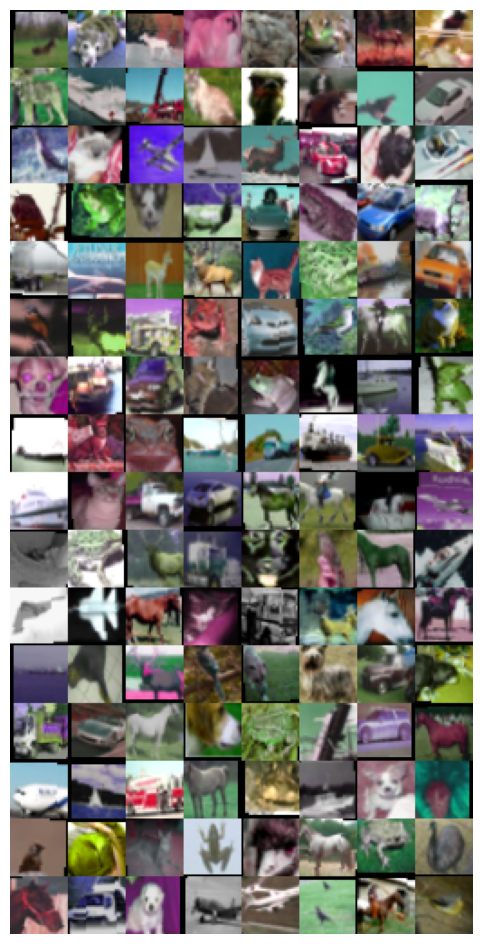

first raw classes horse   dog  deer   dog  frog  frog  deer  bird   dog  ship truck   cat  bird horse  bird automobile
torch.Size([128, 3, 32, 32])


In [ ]:
def imshow(images, nrow = 8,figsize=(16,12), mean=MEAN, std=STD):

    img = torchvision.utils.make_grid(images, nrow = nrow, padding = 0).to(device)

    img = img.transpose(2,0).transpose(0,1)

    std = torch.as_tensor(std).to(device)
    mean = torch.as_tensor(mean).to(device)
    img = (img * std + mean)# unnormalize

    img = img.data.cpu().numpy()

    plt.figure(figsize=(16,12))
    plt.imshow(img); plt.axis('off'); plt.show()


images, labels = next(iter(trainloader))

imshow(images)

print('first raw classes',' '.join('%5s' % names_classes[labels[j]] for j in range(BATCH_SIZE//8)))

print(images.shape)

In [ ]:
def init_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight)
        m.bias.data.fill_(0)

model.apply(init_weights);

In [ ]:
def accuracy(y_pred, y):
    cls_pred = y_pred.argmax(1, keepdim=True)
    correct_cls = cls_pred.eq(y.view_as(cls_pred)).sum()
    acc = correct_cls.float() / y.shape[0]
    return acc

In [ ]:
LR = 0.003

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9)
metric    = accuracy
model     = model.to(device)
criterion = criterion.to(device)

In [ ]:
def train(model, dataloader, optimizer, criterion, metric,  device):

    epoch_loss = 0
    epoch_acc  = 0

    model.train()

    for (x, y) in tqdm(dataloader, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred = model.forward(x)

        loss = criterion(y_pred, y)
        acc  = metric( y_pred, y)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc  += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

In [ ]:
def evaluate(model, dataloader, criterion, metric, device):

    epoch_loss = 0
    epoch_acc  = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(dataloader, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred = model.forward(x)

            loss = criterion(y_pred, y)
            acc  = metric( y_pred, y)

            epoch_loss += loss.item()
            epoch_acc  += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
EPOCHS = 20

train_loss = torch.zeros(EPOCHS)
valid_loss = torch.zeros(EPOCHS)
train_acc  = torch.zeros(EPOCHS)
valid_acc  = torch.zeros(EPOCHS)

best_valid_loss = float('inf')
best_epoch = 0

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss[epoch], train_acc[epoch] = train(model,
                                                trainloader,
                                                optimizer,
                                                criterion,
                                                metric,
                                                device)

    valid_loss[epoch], valid_acc[epoch] = evaluate(model,
                                                   validloader,
                                                   criterion,
                                                   metric,
                                                   device)

    if valid_loss[epoch] < best_valid_loss:
        best_valid_loss = valid_loss[epoch]
        best_epoch = epoch
        torch.save(model.state_dict(), 'lenet_best_model.pt')

    epoch_mins, epoch_secs = epoch_time(start_time, time.monotonic())
    if epoch%2 == 1:    # print every 2 epochs:
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss[epoch]:.3f} | Train Acc: {train_acc[epoch]*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss[epoch]:.3f} |  Val. Acc: {valid_acc[epoch]*100:.2f}%')

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 46s
	Train Loss: 1.896 | Train Acc: 31.82%
	 Val. Loss: 1.737 |  Val. Acc: 37.87%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 45s
	Train Loss: 1.743 | Train Acc: 37.47%
	 Val. Loss: 1.595 |  Val. Acc: 43.87%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 46s
	Train Loss: 1.675 | Train Acc: 39.40%
	 Val. Loss: 1.529 |  Val. Acc: 46.25%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 46s
	Train Loss: 1.633 | Train Acc: 41.29%
	 Val. Loss: 1.482 |  Val. Acc: 47.42%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 54s
	Train Loss: 1.598 | Train Acc: 42.43%
	 Val. Loss: 1.425 |  Val. Acc: 49.69%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 46s
	Train Loss: 1.563 | Train Acc: 44.09%
	 Val. Loss: 1.397 |  Val. Acc: 50.53%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 55s
	Train Loss: 1.541 | Train Acc: 44.53%
	 Val. Loss: 1.380 |  Val. Acc: 51.00%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 47s
	Train Loss: 1.509 | Train Acc: 46.20%
	 Val. Loss: 1.352 |  Val. Acc: 52.23%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 0m 46s
	Train Loss: 1.484 | Train Acc: 47.07%
	 Val. Loss: 1.333 |  Val. Acc: 53.26%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 0m 46s
	Train Loss: 1.469 | Train Acc: 47.75%
	 Val. Loss: 1.308 |  Val. Acc: 54.41%


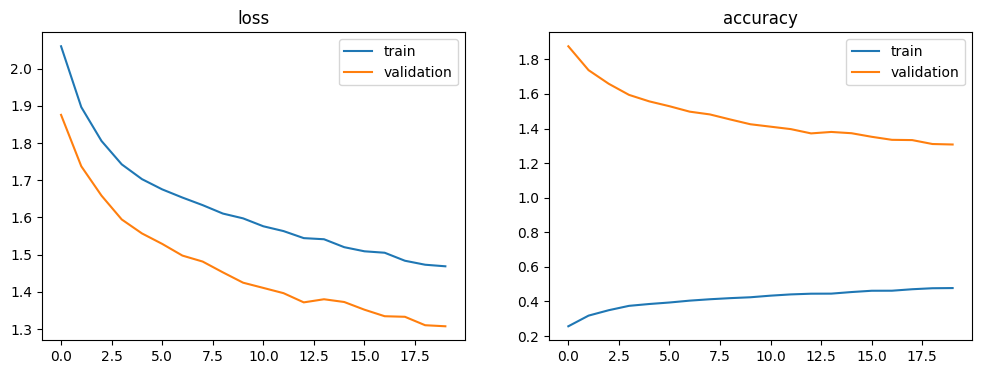

In [ ]:
def plot_results(train_loss, valid_loss, train_acc, valid_acc ):
    fig,axs = plt.subplots(1,2,figsize = (12,4))
    axs[0].plot(train_loss.cpu().numpy(), label = 'train')
    axs[0].plot(valid_loss.cpu().numpy(), label = 'validation')
    axs[0].set_title('loss')
    axs[0].legend()
    axs[1].plot(train_acc.cpu().numpy(), label = 'train')
    axs[1].plot(valid_acc.cpu().numpy(), label = 'validation')
    axs[1].set_title('accuracy')
    axs[1].legend()
    plt.show()

plot_results(train_loss, valid_loss, train_acc, valid_loss )

In [ ]:
model.load_state_dict(torch.load('lenet_best_model.pt'))
test_loss, test_acc = evaluate(model, testloader, criterion, metric, device)
print(f'best epoch {best_epoch}: Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

best epoch 19: Test Loss: 1.291 | Test Acc: 53.93%


In [ ]:
n_classes = 10
n_samples = len(testset)

class_correct = torch.zeros(n_classes)
class_total   = torch.zeros(n_classes)

labels   = []
predicts = []

model.eval()

with torch.no_grad():

    for x,y in tqdm(testloader):
        x = x.to(device)
        y = y.to('cpu')

        y_pred = model.forward(x).to('cpu')

        cls_pred = torch.argmax(y_pred, dim=1)

        c = (cls_pred == y).squeeze() # one-hot vector

        for i in range(x.shape[0]):
            label = y[i]
            class_correct[label] += c[i].item()
            class_total[label]   += 1

        labels.append(y)
        predicts.append(cls_pred)

labels   = torch.cat(labels, dim = 0) # make it 1d array
predicts = torch.cat(predicts, dim = 0) # make it 1d array

for i in range(n_classes):
    print('Accuracy of %5s : %2d %%' % (
        names_classes[i], 100 * class_correct[i] / class_total[i]))

  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy of airplane : 65 %
Accuracy of automobile : 62 %
Accuracy of  bird : 40 %
Accuracy of   cat : 25 %
Accuracy of  deer : 33 %
Accuracy of   dog : 51 %
Accuracy of  frog : 64 %
Accuracy of horse : 63 %
Accuracy of  ship : 67 %
Accuracy of truck : 65 %


Результат с аугментацией 53.93% далее сравним его для случая без аугментации

#### Без аугментации

Посмотрим на результат работы нейронной сети, когда мы не используем дополнительную аугментацию

In [ ]:
MEAN = torch.tensor([0.485, 0.456, 0.406])
STD  = torch.tensor([0.229, 0.224, 0.225])

train_transforms = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize(mean=MEAN, std=STD)
                                      ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=MEAN, std=STD)
                                     ])

In [ ]:

trainset = torchvision.datasets.CIFAR10(root      = './data',
                                        train     = True,
                                        download  = True,
                                        transform = train_transforms)


testset = torchvision.datasets.CIFAR10(root      = './data',
                                       train     = False,
                                       download  = True,
                                       transform = test_transforms)


names_classes = trainset.classes
#('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print('classes:',names_classes)

Files already downloaded and verified
Files already downloaded and verified
classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [ ]:
VALID_RATIO = 0.9

n_train_examples = int(len(trainset) * VALID_RATIO)

n_valid_examples = len(trainset) - n_train_examples

if torch.cuda.is_available():
    kwarg = {'generator':torch.Generator(device='cuda')}
else:
     kwarg = {'generator':torch.Generator(device='cpu')}

trainset, validset = data.random_split(trainset,
                                           [n_train_examples, n_valid_examples], **kwarg)

validset = copy.deepcopy(validset)
validset.dataset.transform = test_transforms

In [ ]:
BATCH_SIZE = 128


if torch.cuda.is_available():
    kwarg = {'generator':torch.Generator(device='cuda')}
else:
     kwarg = {'num_workers':0}

trainloader = data.DataLoader(trainset,shuffle=True,batch_size=BATCH_SIZE, **kwarg)

validloader = data.DataLoader(validset,batch_size=BATCH_SIZE, **kwarg)

testloader  = data.DataLoader(testset,batch_size=BATCH_SIZE, **kwarg)

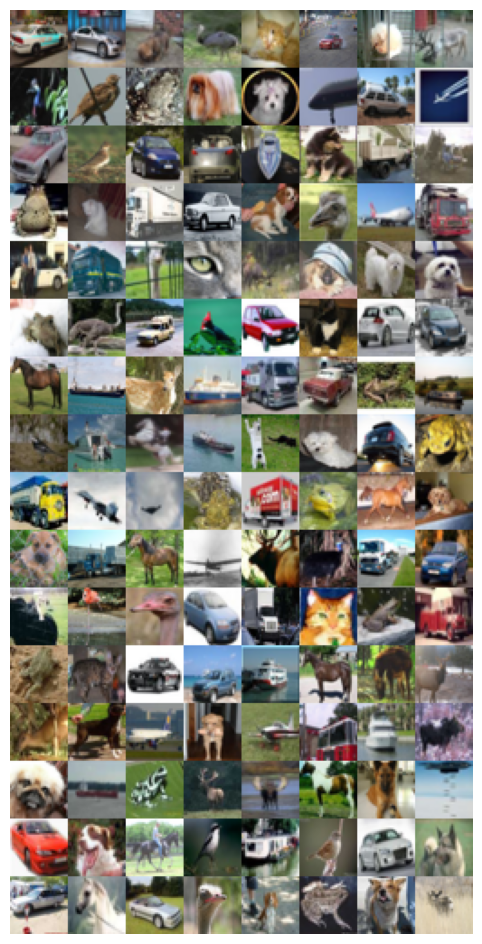

first raw classes automobile automobile   dog  bird   cat automobile   dog  deer  bird  bird  frog   dog   dog airplane automobile airplane
torch.Size([128, 3, 32, 32])


In [ ]:
images, labels = next(iter(trainloader))

imshow(images)

print('first raw classes',' '.join('%5s' % names_classes[labels[j]] for j in range(BATCH_SIZE//8)))

print(images.shape)

In [ ]:
model.apply(init_weights);

In [ ]:
LR = 0.003

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9)
metric    = accuracy
model     = model.to(device)
criterion = criterion.to(device)

In [ ]:
EPOCHS = 20

train_loss = torch.zeros(EPOCHS)
valid_loss = torch.zeros(EPOCHS)
train_acc  = torch.zeros(EPOCHS)
valid_acc  = torch.zeros(EPOCHS)

best_valid_loss = float('inf')
best_epoch = 0

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss[epoch], train_acc[epoch] = train(model,
                                                trainloader,
                                                optimizer,
                                                criterion,
                                                metric,
                                                device)

    valid_loss[epoch], valid_acc[epoch] = evaluate(model,
                                                   validloader,
                                                   criterion,
                                                   metric,
                                                   device)

    if valid_loss[epoch] < best_valid_loss:
        best_valid_loss = valid_loss[epoch]
        best_epoch = epoch
        torch.save(model.state_dict(), 'lenet_best_model.pt')

    epoch_mins, epoch_secs = epoch_time(start_time, time.monotonic())
    if epoch%2 == 1:    # print every 2 epochs:
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss[epoch]:.3f} | Train Acc: {train_acc[epoch]*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss[epoch]:.3f} |  Val. Acc: {valid_acc[epoch]*100:.2f}%')

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 19s
	Train Loss: 1.697 | Train Acc: 40.47%
	 Val. Loss: 1.670 |  Val. Acc: 41.95%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 19s
	Train Loss: 1.548 | Train Acc: 45.42%
	 Val. Loss: 1.544 |  Val. Acc: 46.64%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 18s
	Train Loss: 1.426 | Train Acc: 49.13%
	 Val. Loss: 1.423 |  Val. Acc: 49.39%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 21s
	Train Loss: 1.340 | Train Acc: 52.25%
	 Val. Loss: 1.375 |  Val. Acc: 51.02%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 18s
	Train Loss: 1.281 | Train Acc: 54.31%
	 Val. Loss: 1.328 |  Val. Acc: 52.64%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 18s
	Train Loss: 1.229 | Train Acc: 56.19%
	 Val. Loss: 1.298 |  Val. Acc: 53.32%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 18s
	Train Loss: 1.190 | Train Acc: 57.75%
	 Val. Loss: 1.262 |  Val. Acc: 54.41%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 17s
	Train Loss: 1.152 | Train Acc: 59.14%
	 Val. Loss: 1.258 |  Val. Acc: 55.25%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 0m 18s
	Train Loss: 1.122 | Train Acc: 60.19%
	 Val. Loss: 1.236 |  Val. Acc: 56.46%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 0m 17s
	Train Loss: 1.093 | Train Acc: 60.94%
	 Val. Loss: 1.203 |  Val. Acc: 57.56%


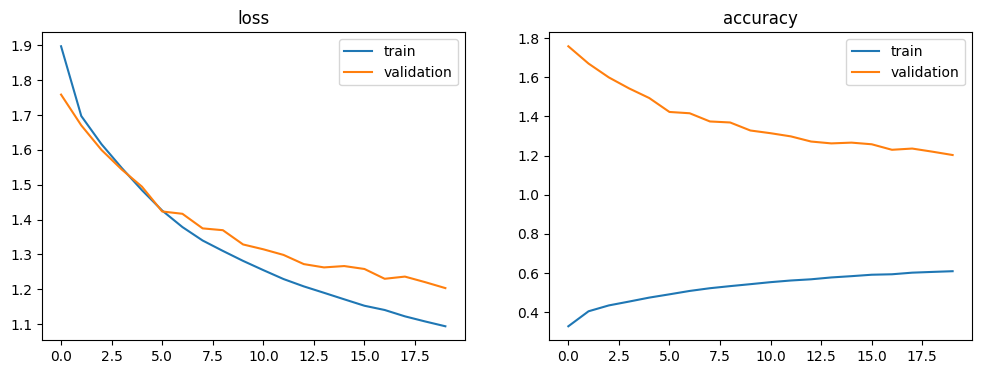

In [ ]:
plot_results(train_loss, valid_loss, train_acc, valid_loss )

In [ ]:
model.load_state_dict(torch.load('lenet_best_model.pt'))
test_loss, test_acc = evaluate(model, testloader, criterion, metric, device)
print(f'best epoch {best_epoch}: Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

best epoch 19: Test Loss: 1.183 | Test Acc: 57.45%


In [ ]:
n_classes = 10
n_samples = len(testset)

class_correct = torch.zeros(n_classes)
class_total   = torch.zeros(n_classes)

labels   = []
predicts = []

model.eval()

with torch.no_grad():

    for x,y in tqdm(testloader):
        x = x.to(device)
        y = y.to('cpu')

        y_pred = model.forward(x).to('cpu')

        cls_pred = torch.argmax(y_pred, dim=1)

        c = (cls_pred == y).squeeze() # one-hot vector

        for i in range(x.shape[0]):
            label = y[i]
            class_correct[label] += c[i].item()
            class_total[label]   += 1

        labels.append(y)
        predicts.append(cls_pred)

labels   = torch.cat(labels, dim = 0) # make it 1d array
predicts = torch.cat(predicts, dim = 0) # make it 1d array

for i in range(n_classes):
    print('Accuracy of %5s : %2d %%' % (
        names_classes[i], 100 * class_correct[i] / class_total[i]))

  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy of airplane : 63 %
Accuracy of automobile : 70 %
Accuracy of  bird : 41 %
Accuracy of   cat : 40 %
Accuracy of  deer : 42 %
Accuracy of   dog : 51 %
Accuracy of  frog : 65 %
Accuracy of horse : 69 %
Accuracy of  ship : 64 %
Accuracy of truck : 65 %


Без аугментации качество улучшилось: accuracy на тесте 57.45%, с аугментацией - 53.93%. Таким образом, для данного набора данных без аугментации мы достигаем лучшее качество. Можно предположить, что тк сеть LeNet была изначально разработана для набора данных MNIST, который является чистым и простым набором данных. В таких случаях сеть может обладать достаточным потенциалом для изучения базовых закономерностей без аугментации.


### 2. Проверьте точность архитектуры если заменить средний пулинг на максимальный

In [ ]:
class LeNet(nn.Module):

    def __init__(self, in_channels, n_classes):
        super().__init__()

        self.in_channels = in_channels
        self.n_classes   = n_classes

        # convolution
        self.conv1   = nn.Conv2d(in_channels  = self.in_channels,
                                 out_channels = 6,
                                 kernel_size  = 5)


        self.conv2   = nn.Conv2d(in_channels  = 6,
                                 out_channels = 16,
                                 kernel_size  = 5)

        # pooling
        self.pool = nn.MaxPool2d(kernel_size = 2,
                                 stride      = 2)

        # classification
        self.fc1 = nn.Linear(in_features  = 16 * 5 * 5,
                             out_features = 120)

        self.fc2 = nn.Linear(in_features  = 120,
                             out_features = 84)

        self.fc_out = nn.Linear(in_features = 84,
                                out_features = self.n_classes)

    def flatten(self, x):
        # 16 feature map with size 5 x 5
        return x.view(-1, 16 * 5 * 5)

    def forward(self, x):

        # 1-st layer
        x = self.conv1(x)
        x = torch.tanh(x)
        x = self.pool(x)

        #2-nd layer
        x = self.conv2(x)
        x = torch.tanh(x)
        x = self.pool(x)

        #flatten
        x = self.flatten(x)

        # 1-st fc layer
        x = self.fc1(x)
        x = torch.tanh(x)

        # 2-nd fc layer
        x = self.fc2(x)
        x = torch.tanh(x)

        # output layer
        x = self.fc_out(x)

        return x#torch.softmax(x, dim=1)

In [ ]:
model = LeNet(3,10)

# from torchsummary import summary
summary(model, input_size = (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


In [ ]:
params = list(model.named_parameters())

# print(params)
for idx in range(len(params)):
    print(params[idx][0],'\t', params[idx][1].size())
print('\n',10*'--')
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of trainable parameters for the model: %d' % (num_params))

num_params = sum(p.numel() for p in model.parameters() )
print('Number of all parameters for the model: %d' % (num_params))

conv1.weight 	 torch.Size([6, 3, 5, 5])
conv1.bias 	 torch.Size([6])
conv2.weight 	 torch.Size([16, 6, 5, 5])
conv2.bias 	 torch.Size([16])
fc1.weight 	 torch.Size([120, 400])
fc1.bias 	 torch.Size([120])
fc2.weight 	 torch.Size([84, 120])
fc2.bias 	 torch.Size([84])
fc_out.weight 	 torch.Size([10, 84])
fc_out.bias 	 torch.Size([10])

 --------------------
Number of trainable parameters for the model: 62006
Number of all parameters for the model: 62006


Поскольку без аугментации качество лучше, не будем ее использовать (только нормализацию)

In [ ]:
MEAN = torch.tensor([0.485, 0.456, 0.406])
STD  = torch.tensor([0.229, 0.224, 0.225])

train_transforms = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize(mean=MEAN, std=STD)
                                      ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=MEAN, std=STD)
                                     ])

In [ ]:

trainset = torchvision.datasets.CIFAR10(root      = './data',
                                        train     = True,
                                        download  = True,
                                        transform = train_transforms)


testset = torchvision.datasets.CIFAR10(root      = './data',
                                       train     = False,
                                       download  = True,
                                       transform = test_transforms)


names_classes = trainset.classes
#('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print('classes:',names_classes)

Files already downloaded and verified
Files already downloaded and verified
classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [ ]:
VALID_RATIO = 0.9

n_train_examples = int(len(trainset) * VALID_RATIO)

n_valid_examples = len(trainset) - n_train_examples

if torch.cuda.is_available():
    kwarg = {'generator':torch.Generator(device='cuda')}
else:
     kwarg = {'generator':torch.Generator(device='cpu')}

trainset, validset = data.random_split(trainset,
                                           [n_train_examples, n_valid_examples], **kwarg)

validset = copy.deepcopy(validset)
validset.dataset.transform = test_transforms

In [ ]:
BATCH_SIZE = 128


if torch.cuda.is_available():
    kwarg = {'generator':torch.Generator(device='cuda')}
else:
     kwarg = {'num_workers':0}

trainloader = data.DataLoader(trainset,shuffle=True,batch_size=BATCH_SIZE, **kwarg)

validloader = data.DataLoader(validset,batch_size=BATCH_SIZE, **kwarg)

testloader  = data.DataLoader(testset,batch_size=BATCH_SIZE, **kwarg)

In [ ]:
model.apply(init_weights);

In [ ]:
LR = 0.003

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9)
metric    = accuracy
model     = model.to(device)
criterion = criterion.to(device)

In [ ]:
EPOCHS = 20

train_loss = torch.zeros(EPOCHS)
valid_loss = torch.zeros(EPOCHS)
train_acc  = torch.zeros(EPOCHS)
valid_acc  = torch.zeros(EPOCHS)

best_valid_loss = float('inf')
best_epoch = 0

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss[epoch], train_acc[epoch] = train(model,
                                                trainloader,
                                                optimizer,
                                                criterion,
                                                metric,
                                                device)

    valid_loss[epoch], valid_acc[epoch] = evaluate(model,
                                                   validloader,
                                                   criterion,
                                                   metric,
                                                   device)

    if valid_loss[epoch] < best_valid_loss:
        best_valid_loss = valid_loss[epoch]
        best_epoch = epoch
        torch.save(model.state_dict(), 'lenet_best_model.pt')

    epoch_mins, epoch_secs = epoch_time(start_time, time.monotonic())
    if epoch%2 == 1:    # print every 2 epochs:
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss[epoch]:.3f} | Train Acc: {train_acc[epoch]*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss[epoch]:.3f} |  Val. Acc: {valid_acc[epoch]*100:.2f}%')

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 18s
	Train Loss: 1.559 | Train Acc: 44.41%
	 Val. Loss: 1.501 |  Val. Acc: 47.15%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 18s
	Train Loss: 1.381 | Train Acc: 50.66%
	 Val. Loss: 1.358 |  Val. Acc: 52.56%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 18s
	Train Loss: 1.265 | Train Acc: 54.88%
	 Val. Loss: 1.257 |  Val. Acc: 56.39%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 19s
	Train Loss: 1.191 | Train Acc: 57.89%
	 Val. Loss: 1.208 |  Val. Acc: 57.89%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 18s
	Train Loss: 1.132 | Train Acc: 59.89%
	 Val. Loss: 1.202 |  Val. Acc: 57.83%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 18s
	Train Loss: 1.089 | Train Acc: 61.38%
	 Val. Loss: 1.144 |  Val. Acc: 60.21%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 18s
	Train Loss: 1.047 | Train Acc: 63.11%
	 Val. Loss: 1.133 |  Val. Acc: 60.78%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 18s
	Train Loss: 1.007 | Train Acc: 64.55%
	 Val. Loss: 1.128 |  Val. Acc: 61.02%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 0m 18s
	Train Loss: 0.978 | Train Acc: 65.62%
	 Val. Loss: 1.115 |  Val. Acc: 61.27%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 0m 18s
	Train Loss: 0.948 | Train Acc: 66.57%
	 Val. Loss: 1.119 |  Val. Acc: 60.92%


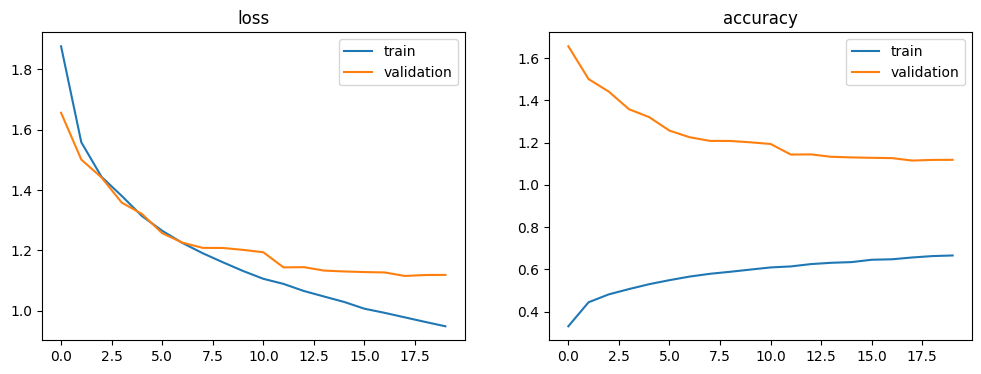

In [ ]:
plot_results(train_loss, valid_loss, train_acc, valid_loss )

In [ ]:
model.load_state_dict(torch.load('lenet_best_model.pt'))
test_loss, test_acc = evaluate(model, testloader, criterion, metric, device)
print(f'best epoch {best_epoch}: Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

best epoch 17: Test Loss: 1.121 | Test Acc: 60.09%


In [ ]:
n_classes = 10
n_samples = len(testset)

class_correct = torch.zeros(n_classes)
class_total   = torch.zeros(n_classes)

labels   = []
predicts = []

model.eval()

with torch.no_grad():

    for x,y in tqdm(testloader):
        x = x.to(device)
        y = y.to('cpu')

        y_pred = model.forward(x).to('cpu')

        cls_pred = torch.argmax(y_pred, dim=1)

        c = (cls_pred == y).squeeze() # one-hot vector

        for i in range(x.shape[0]):
            label = y[i]
            class_correct[label] += c[i].item()
            class_total[label]   += 1

        labels.append(y)
        predicts.append(cls_pred)

labels   = torch.cat(labels, dim = 0) # make it 1d array
predicts = torch.cat(predicts, dim = 0) # make it 1d array

for i in range(n_classes):
    print('Accuracy of %5s : %2d %%' % (
        names_classes[i], 100 * class_correct[i] / class_total[i]))

  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy of airplane : 69 %
Accuracy of automobile : 70 %
Accuracy of  bird : 50 %
Accuracy of   cat : 39 %
Accuracy of  deer : 46 %
Accuracy of   dog : 38 %
Accuracy of  frog : 78 %
Accuracy of horse : 66 %
Accuracy of  ship : 73 %
Accuracy of truck : 67 %


С AvgPooling - accuracy 57.45%, с MaxPooling - accuracy 60.09%, те результат улучшился.

Скорее всего, это связано с тем, что Max-pooling выбирает максимальное значение активации в пределах окна. Это обеспечивает сохранение наиболее характерных и значимых признаков. Max-pooling помогает сети сосредоточиться на наиболее значимой информации, что делает его особенно полезным при необходимости обнаружения специфических особенностей. Также он может быть устойчив к небольшим вариациям и шуму в данных, поскольку выбирает максимальное значение.

### 3.Проверьте точность архитектуры если заменить оптимизатор на Adam и на RMS Prop.

#### Adam

In [ ]:
LR = 0.003

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR,)
metric    = accuracy
model     = model.to(device)
criterion = criterion.to(device)

In [ ]:
EPOCHS = 20

train_loss = torch.zeros(EPOCHS)
valid_loss = torch.zeros(EPOCHS)
train_acc  = torch.zeros(EPOCHS)
valid_acc  = torch.zeros(EPOCHS)

best_valid_loss = float('inf')
best_epoch = 0

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss[epoch], train_acc[epoch] = train(model,
                                                trainloader,
                                                optimizer,
                                                criterion,
                                                metric,
                                                device)

    valid_loss[epoch], valid_acc[epoch] = evaluate(model,
                                                   validloader,
                                                   criterion,
                                                   metric,
                                                   device)

    if valid_loss[epoch] < best_valid_loss:
        best_valid_loss = valid_loss[epoch]
        best_epoch = epoch
        torch.save(model.state_dict(), 'lenet_best_model.pt')

    epoch_mins, epoch_secs = epoch_time(start_time, time.monotonic())
    if epoch%2 == 1:    # print every 2 epochs:
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss[epoch]:.3f} | Train Acc: {train_acc[epoch]*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss[epoch]:.3f} |  Val. Acc: {valid_acc[epoch]*100:.2f}%')

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 22s
	Train Loss: 1.028 | Train Acc: 63.63%
	 Val. Loss: 1.211 |  Val. Acc: 58.69%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 18s
	Train Loss: 0.915 | Train Acc: 67.54%
	 Val. Loss: 1.105 |  Val. Acc: 61.78%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 20s
	Train Loss: 0.817 | Train Acc: 71.31%
	 Val. Loss: 1.163 |  Val. Acc: 60.00%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 20s
	Train Loss: 0.746 | Train Acc: 73.47%
	 Val. Loss: 1.199 |  Val. Acc: 59.57%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 18s
	Train Loss: 0.689 | Train Acc: 75.71%
	 Val. Loss: 1.254 |  Val. Acc: 59.38%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 18s
	Train Loss: 0.624 | Train Acc: 78.01%
	 Val. Loss: 1.313 |  Val. Acc: 59.88%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 19s
	Train Loss: 0.593 | Train Acc: 78.97%
	 Val. Loss: 1.385 |  Val. Acc: 59.14%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 20s
	Train Loss: 0.552 | Train Acc: 80.27%
	 Val. Loss: 1.428 |  Val. Acc: 58.50%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 0m 20s
	Train Loss: 0.503 | Train Acc: 82.16%
	 Val. Loss: 1.450 |  Val. Acc: 59.12%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 0m 18s
	Train Loss: 0.488 | Train Acc: 82.57%
	 Val. Loss: 1.530 |  Val. Acc: 58.14%


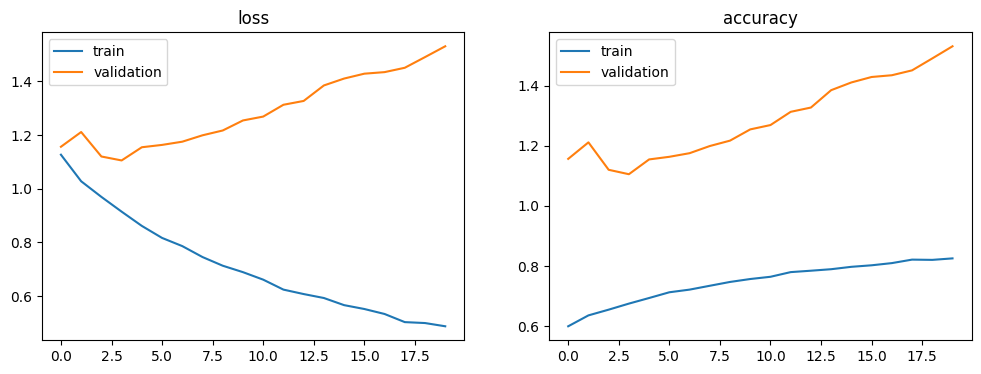

In [ ]:
plot_results(train_loss, valid_loss, train_acc, valid_loss )

In [ ]:
model.load_state_dict(torch.load('lenet_best_model.pt'))
test_loss, test_acc = evaluate(model, testloader, criterion, metric, device)
print(f'best epoch {best_epoch}: Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

best epoch 3: Test Loss: 1.116 | Test Acc: 61.32%


Качество чуть лучше, при использовании Adam,однако, мы видим, что практически сразу начинается переобучение, что является не очень хорошим знаком

#### RMS Prop

In [ ]:
LR = 0.003

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=LR, momentum=0.9)
metric    = accuracy
model     = model.to(device)
criterion = criterion.to(device)

In [ ]:
EPOCHS = 20

train_loss = torch.zeros(EPOCHS)
valid_loss = torch.zeros(EPOCHS)
train_acc  = torch.zeros(EPOCHS)
valid_acc  = torch.zeros(EPOCHS)

best_valid_loss = float('inf')
best_epoch = 0

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss[epoch], train_acc[epoch] = train(model,
                                                trainloader,
                                                optimizer,
                                                criterion,
                                                metric,
                                                device)

    valid_loss[epoch], valid_acc[epoch] = evaluate(model,
                                                   validloader,
                                                   criterion,
                                                   metric,
                                                   device)

    if valid_loss[epoch] < best_valid_loss:
        best_valid_loss = valid_loss[epoch]
        best_epoch = epoch
        torch.save(model.state_dict(), 'lenet_best_model.pt')

    epoch_mins, epoch_secs = epoch_time(start_time, time.monotonic())
    if epoch%2 == 1:    # print every 2 epochs:
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss[epoch]:.3f} | Train Acc: {train_acc[epoch]*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss[epoch]:.3f} |  Val. Acc: {valid_acc[epoch]*100:.2f}%')

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 17s
	Train Loss: 2.073 | Train Acc: 25.31%
	 Val. Loss: 2.051 |  Val. Acc: 27.05%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 17s
	Train Loss: 2.051 | Train Acc: 26.24%
	 Val. Loss: 2.049 |  Val. Acc: 26.05%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 17s
	Train Loss: 2.025 | Train Acc: 27.98%
	 Val. Loss: 2.005 |  Val. Acc: 28.57%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 17s
	Train Loss: 2.072 | Train Acc: 25.50%
	 Val. Loss: 2.111 |  Val. Acc: 24.49%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 22s
	Train Loss: 2.058 | Train Acc: 26.09%
	 Val. Loss: 1.998 |  Val. Acc: 27.30%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 20s
	Train Loss: 2.058 | Train Acc: 26.14%
	 Val. Loss: 2.036 |  Val. Acc: 26.66%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 17s
	Train Loss: 2.063 | Train Acc: 25.31%
	 Val. Loss: 2.089 |  Val. Acc: 24.90%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 16s
	Train Loss: 2.084 | Train Acc: 25.45%
	 Val. Loss: 2.087 |  Val. Acc: 26.31%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 0m 16s
	Train Loss: 2.062 | Train Acc: 26.48%
	 Val. Loss: 2.071 |  Val. Acc: 26.31%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 0m 17s
	Train Loss: 2.078 | Train Acc: 25.60%
	 Val. Loss: 2.069 |  Val. Acc: 26.39%


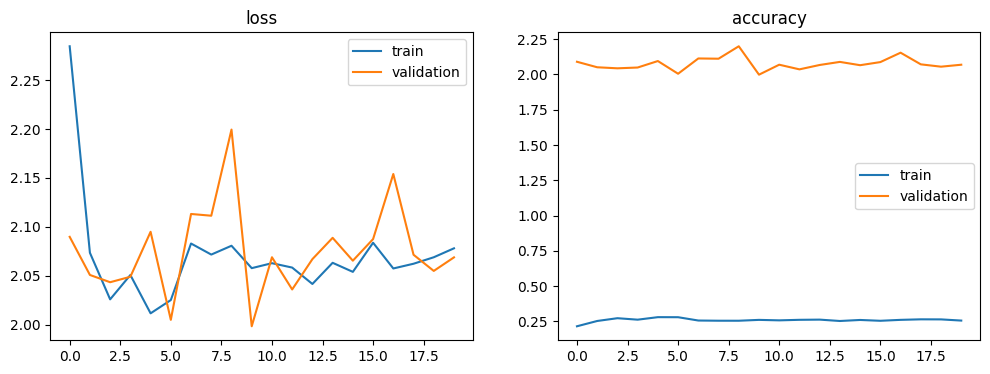

In [ ]:
plot_results(train_loss, valid_loss, train_acc, valid_loss )

In [ ]:
model.load_state_dict(torch.load('lenet_best_model.pt'))
test_loss, test_acc = evaluate(model, testloader, criterion, metric, device)
print(f'best epoch {best_epoch}: Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

best epoch 9: Test Loss: 2.013 | Test Acc: 26.74%


RMS Prop показал плохое качество, также видно что Loss сильно скачет, возможно он не подходит для данной задачи, или необходимо проводить настройку гиперпараметров

В целом можно сделать вывод, что лучше отдавать предпочтение SGD with momentum!

### 4. Проверьте на сколько снижается точность если убрать один полносвязный слой из архитектуры LeNet.

In [ ]:
class LeNet(nn.Module):

    def __init__(self, in_channels, n_classes):
        super().__init__()

        self.in_channels = in_channels
        self.n_classes   = n_classes

        # convolution
        self.conv1   = nn.Conv2d(in_channels  = self.in_channels,
                                 out_channels = 6,
                                 kernel_size  = 5)


        self.conv2   = nn.Conv2d(in_channels  = 6,
                                 out_channels = 16,
                                 kernel_size  = 5)

        # pooling
        self.pool = nn.MaxPool2d(kernel_size = 2,
                                 stride      = 2)

        # # classification
        self.fc1 = nn.Linear(in_features  = 16 * 5 * 5,
                             out_features = 120)

        # self.fc2 = nn.Linear(in_features  = 120,
        #                      out_features = 84)

        self.fc_out = nn.Linear(in_features = 120,
                                out_features = self.n_classes)

    def flatten(self, x):
        # 16 feature map with size 5 x 5
        return x.view(-1, 16 * 5 * 5)

    def forward(self, x):

        # 1-st layer
        x = self.conv1(x)
        x = torch.tanh(x)
        x = self.pool(x)

        #2-nd layer
        x = self.conv2(x)
        x = torch.tanh(x)
        x = self.pool(x)

        #flatten
        x = self.flatten(x)

        # # 1-st fc layer
        x = self.fc1(x)
        x = torch.tanh(x)

        # 2-nd fc layer
        # x = self.fc2(x)
        # x = torch.tanh(x)

        # output layer
        x = self.fc_out(x)

        return x#torch.softmax(x, dim=1)

In [ ]:
model = LeNet(3,10)

# from torchsummary import summary
summary(model, input_size = (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 10]           1,210
Total params: 52,202
Trainable params: 52,202
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.20
Estimated Total Size (MB): 0.27
----------------------------------------------------------------


In [ ]:
params = list(model.named_parameters())

# print(params)
for idx in range(len(params)):
    print(params[idx][0],'\t', params[idx][1].size())
print('\n',10*'--')
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of trainable parameters for the model: %d' % (num_params))

num_params = sum(p.numel() for p in model.parameters() )
print('Number of all parameters for the model: %d' % (num_params))

conv1.weight 	 torch.Size([6, 3, 5, 5])
conv1.bias 	 torch.Size([6])
conv2.weight 	 torch.Size([16, 6, 5, 5])
conv2.bias 	 torch.Size([16])
fc1.weight 	 torch.Size([120, 400])
fc1.bias 	 torch.Size([120])
fc_out.weight 	 torch.Size([10, 120])
fc_out.bias 	 torch.Size([10])

 --------------------
Number of trainable parameters for the model: 52202
Number of all parameters for the model: 52202


In [ ]:
model.apply(init_weights);

In [ ]:
LR = 0.003

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9)
metric    = accuracy
model     = model.to(device)
criterion = criterion.to(device)

In [ ]:
EPOCHS = 20

train_loss = torch.zeros(EPOCHS)
valid_loss = torch.zeros(EPOCHS)
train_acc  = torch.zeros(EPOCHS)
valid_acc  = torch.zeros(EPOCHS)

best_valid_loss = float('inf')
best_epoch = 0

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss[epoch], train_acc[epoch] = train(model,
                                                trainloader,
                                                optimizer,
                                                criterion,
                                                metric,
                                                device)

    valid_loss[epoch], valid_acc[epoch] = evaluate(model,
                                                   validloader,
                                                   criterion,
                                                   metric,
                                                   device)

    if valid_loss[epoch] < best_valid_loss:
        best_valid_loss = valid_loss[epoch]
        best_epoch = epoch
        torch.save(model.state_dict(), 'lenet_best_model.pt')

    epoch_mins, epoch_secs = epoch_time(start_time, time.monotonic())
    if epoch%2 == 1:    # print every 2 epochs:
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss[epoch]:.3f} | Train Acc: {train_acc[epoch]*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss[epoch]:.3f} |  Val. Acc: {valid_acc[epoch]*100:.2f}%')

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 24s
	Train Loss: 1.563 | Train Acc: 44.59%
	 Val. Loss: 1.500 |  Val. Acc: 46.05%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 24s
	Train Loss: 1.382 | Train Acc: 51.04%
	 Val. Loss: 1.354 |  Val. Acc: 52.05%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 18s
	Train Loss: 1.283 | Train Acc: 54.53%
	 Val. Loss: 1.293 |  Val. Acc: 55.12%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 18s
	Train Loss: 1.211 | Train Acc: 57.16%
	 Val. Loss: 1.239 |  Val. Acc: 57.25%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 18s
	Train Loss: 1.161 | Train Acc: 59.20%
	 Val. Loss: 1.249 |  Val. Acc: 56.41%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 17s
	Train Loss: 1.120 | Train Acc: 60.72%
	 Val. Loss: 1.194 |  Val. Acc: 58.34%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 18s
	Train Loss: 1.082 | Train Acc: 62.14%
	 Val. Loss: 1.168 |  Val. Acc: 58.14%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 17s
	Train Loss: 1.062 | Train Acc: 62.84%
	 Val. Loss: 1.169 |  Val. Acc: 59.02%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 0m 17s
	Train Loss: 1.030 | Train Acc: 64.02%
	 Val. Loss: 1.131 |  Val. Acc: 60.06%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 0m 18s
	Train Loss: 1.013 | Train Acc: 64.62%
	 Val. Loss: 1.127 |  Val. Acc: 60.53%


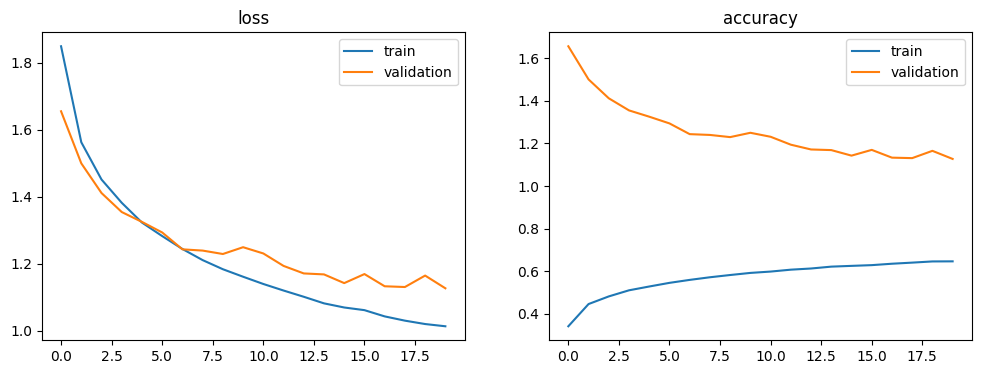

In [ ]:
plot_results(train_loss, valid_loss, train_acc, valid_loss )

In [ ]:
model.load_state_dict(torch.load('lenet_best_model.pt'))
test_loss, test_acc = evaluate(model, testloader, criterion, metric, device)
print(f'best epoch {best_epoch}: Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

best epoch 19: Test Loss: 1.126 | Test Acc: 60.31%


С MaxPooling предыдущий резульатт был - 60.09%, в данном эксперименте также с MaxPooling, но без одного полносвязного слоя результат практически не изменился - 60.31%

Давайте для объективности посмотрим на результат работы нс с AvgPooling и также без одного полносвязного слоя

In [ ]:
class LeNet(nn.Module):

    def __init__(self, in_channels, n_classes):
        super().__init__()

        self.in_channels = in_channels
        self.n_classes   = n_classes

        # convolution
        self.conv1   = nn.Conv2d(in_channels  = self.in_channels,
                                 out_channels = 6,
                                 kernel_size  = 5)


        self.conv2   = nn.Conv2d(in_channels  = 6,
                                 out_channels = 16,
                                 kernel_size  = 5)

        # pooling
        self.pool = nn.AvgPool2d(kernel_size = 2,
                                 stride      = 2)

        # # classification
        self.fc1 = nn.Linear(in_features  = 16 * 5 * 5,
                             out_features = 120)

        # self.fc2 = nn.Linear(in_features  = 120,
        #                      out_features = 84)

        self.fc_out = nn.Linear(in_features = 120,
                                out_features = self.n_classes)

    def flatten(self, x):
        # 16 feature map with size 5 x 5
        return x.view(-1, 16 * 5 * 5)

    def forward(self, x):

        # 1-st layer
        x = self.conv1(x)
        x = torch.tanh(x)
        x = self.pool(x)

        #2-nd layer
        x = self.conv2(x)
        x = torch.tanh(x)
        x = self.pool(x)

        #flatten
        x = self.flatten(x)

        # # 1-st fc layer
        x = self.fc1(x)
        x = torch.tanh(x)

        # 2-nd fc layer
        # x = self.fc2(x)
        # x = torch.tanh(x)

        # output layer
        x = self.fc_out(x)

        return x#torch.softmax(x, dim=1)

In [ ]:
model = LeNet(3,10)

# from torchsummary import summary
summary(model, input_size = (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         AvgPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         AvgPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 10]           1,210
Total params: 52,202
Trainable params: 52,202
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.20
Estimated Total Size (MB): 0.27
----------------------------------------------------------------


In [ ]:
params = list(model.named_parameters())

# print(params)
for idx in range(len(params)):
    print(params[idx][0],'\t', params[idx][1].size())
print('\n',10*'--')
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of trainable parameters for the model: %d' % (num_params))

num_params = sum(p.numel() for p in model.parameters() )
print('Number of all parameters for the model: %d' % (num_params))

conv1.weight 	 torch.Size([6, 3, 5, 5])
conv1.bias 	 torch.Size([6])
conv2.weight 	 torch.Size([16, 6, 5, 5])
conv2.bias 	 torch.Size([16])
fc1.weight 	 torch.Size([120, 400])
fc1.bias 	 torch.Size([120])
fc_out.weight 	 torch.Size([10, 120])
fc_out.bias 	 torch.Size([10])

 --------------------
Number of trainable parameters for the model: 52202
Number of all parameters for the model: 52202


In [ ]:
model.apply(init_weights);

In [ ]:
LR = 0.003

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9)
metric    = accuracy
model     = model.to(device)
criterion = criterion.to(device)

In [ ]:
EPOCHS = 20

train_loss = torch.zeros(EPOCHS)
valid_loss = torch.zeros(EPOCHS)
train_acc  = torch.zeros(EPOCHS)
valid_acc  = torch.zeros(EPOCHS)

best_valid_loss = float('inf')
best_epoch = 0

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss[epoch], train_acc[epoch] = train(model,
                                                trainloader,
                                                optimizer,
                                                criterion,
                                                metric,
                                                device)

    valid_loss[epoch], valid_acc[epoch] = evaluate(model,
                                                   validloader,
                                                   criterion,
                                                   metric,
                                                   device)

    if valid_loss[epoch] < best_valid_loss:
        best_valid_loss = valid_loss[epoch]
        best_epoch = epoch
        torch.save(model.state_dict(), 'lenet_best_model.pt')

    epoch_mins, epoch_secs = epoch_time(start_time, time.monotonic())
    if epoch%2 == 1:    # print every 2 epochs:
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss[epoch]:.3f} | Train Acc: {train_acc[epoch]*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss[epoch]:.3f} |  Val. Acc: {valid_acc[epoch]*100:.2f}%')

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 17s
	Train Loss: 1.682 | Train Acc: 41.13%
	 Val. Loss: 1.645 |  Val. Acc: 42.29%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 17s
	Train Loss: 1.517 | Train Acc: 46.18%
	 Val. Loss: 1.506 |  Val. Acc: 47.29%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 17s
	Train Loss: 1.430 | Train Acc: 49.16%
	 Val. Loss: 1.444 |  Val. Acc: 48.42%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 17s
	Train Loss: 1.367 | Train Acc: 51.53%
	 Val. Loss: 1.385 |  Val. Acc: 50.92%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 17s
	Train Loss: 1.312 | Train Acc: 53.40%
	 Val. Loss: 1.351 |  Val. Acc: 51.76%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 17s
	Train Loss: 1.274 | Train Acc: 54.81%
	 Val. Loss: 1.308 |  Val. Acc: 54.28%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 17s
	Train Loss: 1.239 | Train Acc: 55.94%
	 Val. Loss: 1.293 |  Val. Acc: 53.95%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 17s
	Train Loss: 1.211 | Train Acc: 56.98%
	 Val. Loss: 1.258 |  Val. Acc: 54.71%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 0m 17s
	Train Loss: 1.186 | Train Acc: 57.91%
	 Val. Loss: 1.259 |  Val. Acc: 55.16%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 0m 17s
	Train Loss: 1.158 | Train Acc: 59.12%
	 Val. Loss: 1.230 |  Val. Acc: 55.88%


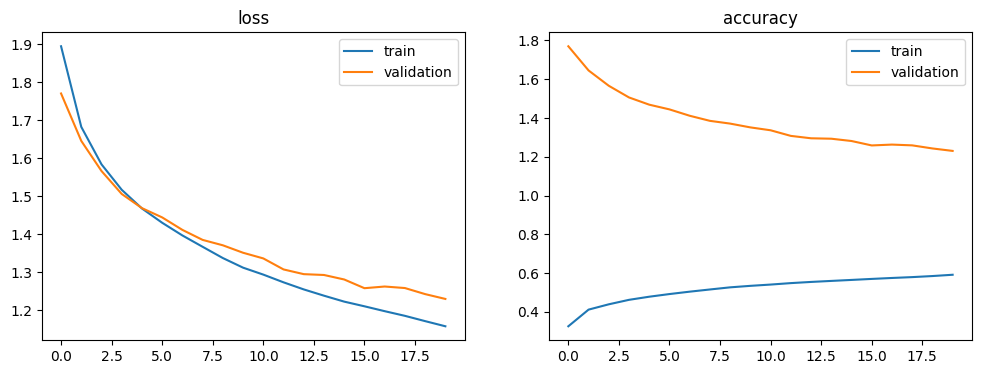

In [ ]:
plot_results(train_loss, valid_loss, train_acc, valid_loss )

In [ ]:
model.load_state_dict(torch.load('lenet_best_model.pt'))
test_loss, test_acc = evaluate(model, testloader, criterion, metric, device)
print(f'best epoch {best_epoch}: Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

best epoch 19: Test Loss: 1.234 | Test Acc: 55.92%


Для случая с AvgPooling (те так как в архитектуре LeNet) в случае, когда мы убирем один полносвязный слой качество ухудшается с 57.5% до 55.92%

Таким образом, я считаю, что это связано с тем, что каждый полносвязный слой добавляет в модель значительное число параметров. Эти параметры используются для отражения сложных взаимосвязей в данных. Удаление одного полносвязного слоя снижает способность модели к обучению этим взаимосвязям, что может привести к недоучету данных. Для сложных задач модель с меньшей емкостью может оказаться недостаточно репрезентативной.